# UK Non-Fiction Book Price Model, 2024

In this project we will be working with a dataset of non-fiction hardback and paperback books from 2014&ndash;2023.

The dataset is made up of the top 5,000 titles for each year as sold through Nielsen Bookscan's Total Consumer Market in the UK.

Additional datapoints for each title were added from Goodreads (GR) and Google Books (GB). (*Please see README.md for a note on the methodology.*)

The stated aim of the project is:

**To develop a model that can accurately predict the RRP for a non-fiction book using the provided data.**

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Initialising dataset

In [2]:
df = pd.read_csv("./data/final_books_dataset.csv")
df.head()

,ISBN,Sales_Year,Position,Title,Author,Imprint,Publisher Group,Volume,Value,RRP,...,Product Class,GR_Title,GR_Author,GR_Rating,GR_Pages,GB_Title,GB_Author,GB_Desc,GB_Pages,GB_Genre
0,9781908843623,2014,1,Guinness World Records 2015,NaN,Guinness World Records,Guinness Publisher Group,405871,3593173.92,20.00,...,T2.0 Encyclopedias & General Reference,Guinness World Records 2015,Na,4.14,256.0,NaN,NaN,NaN,NaN,NaN
1,9781473608566,2014,2,There's Something I've Been Dying to Tell You:...,"Bellingham, Lynda",Coronet Books,Hodder & Stoughton Grp,329612,3014401.23,16.99,...,T4.1A Autobiography: The Arts,There's Something I've Been Dying to Tell You,Lynda Bellingham,4.02,275.0,There's Something I've Been Dying to Tell You,['Lynda Bellingham'],In 2013 Lynda Bellingham was diagnosed with ca...,288.0,['Cancer']
2,9781849906630,2014,3,Mary Berry Cooks,"Berry, Mary",BBC Books (Random House),Random House Grp,267875,2877125.17,30.00,...,T16.0 Food & Drink: General,Mary Berry Cooks,Mary Berry,4.34,320.0,Mary Berry Cooks,['Mary Berry'],100 classic recipes from Mary Berry's personal...,324.0,['Cooking']
3,9780718159535,2014,4,Jamie's Comfort Food,"Oliver, Jamie",Michael Joseph,Penguin Grp,254403,3274420.76,30.00,...,T16.0 Food & Drink: General,Jamie's Comfort Food,Jamie Oliver,4.16,408.0,Jamie's Comfort Food,['Jamie Oliver'],Jamie's new cookbook brings together 100 ultim...,0.0,['Cooking']
4,9780753555026,2014,5,Guy Martin:My Autobiography,"Martin, Guy",Virgin Books,Random House Grp,220548,2483303.04,20.00,...,T4.4A Autobiography: Sport,Guy Martin: My Autobiography,Guy Martin,4.06,320.0,Guy Martin - My Autobiography,['Guy Martin'],The story of life at the center of the world's...,324.0,['Biography']


In [3]:
df.shape # 50,000 rows, 23 columns

(50000, 23)

Select columns of interest

In [4]:
df = df[["Sales_Year", "Publisher Group", "RRP", "ASP", "Binding", "Publ Date", "Product Class", "GR_Pages", "GB_Pages"]]
df.head() # 50,000 rows, 8 columns

,Sales_Year,Publisher Group,RRP,ASP,Binding,Publ Date,Product Class,GR_Pages,GB_Pages
0,2014,Guinness Publisher Group,20.00,8.852995,Hardback,11/09/2014,T2.0 Encyclopedias & General Reference,256.0,NaN
1,2014,Hodder & Stoughton Grp,16.99,9.145302,Hardback,09/10/2014,T4.1A Autobiography: The Arts,275.0,288.0
2,2014,Random House Grp,30.00,10.740551,Hardback,27/02/2014,T16.0 Food & Drink: General,320.0,324.0
3,2014,Penguin Grp,30.00,12.870999,Hardback,28/08/2014,T16.0 Food & Drink: General,408.0,0.0
4,2014,Random House Grp,20.00,11.259694,Hardback,08/05/2014,T4.4A Autobiography: Sport,320.0,324.0


# Cleaning, completing and converting data

## Initial Overview

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sales_Year       50000 non-null  int64  
 1   Publisher Group  50000 non-null  object 
 2   RRP              49121 non-null  float64
 3   ASP              50000 non-null  float64
 4   Binding          50000 non-null  object 
 5   Publ Date        50000 non-null  object 
 6   Product Class    50000 non-null  object 
 7   GR_Pages         46845 non-null  float64
 8   GB_Pages         43982 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 3.4+ MB


In [6]:
# Display nulls per column
df.isnull().sum()

Sales_Year            0
Publisher Group       0
RRP                 879
ASP                   0
Binding               0
Publ Date             0
Product Class         0
GR_Pages           3155
GB_Pages           6018
dtype: int64

## RRPs

In [7]:
df["RRP"].describe()

count    49121.000000
mean        14.190612
std          6.931540
min          0.200000
25%          9.990000
50%         12.990000
75%         16.990000
max        141.990000
Name: RRP, dtype: float64

Reasonably high overall variance in RRPs - will need to normalise and remove any significant outliers as well as filling nulls. First calculate mean values per binding:

In [8]:
print(df["RRP"].loc[(df["Binding"] == "Paperback")].mean()) # Mean paperback RRP = ~£11.55
print(df["RRP"].loc[(df["Binding"] == "Hardback")].mean()) # Mean hardback RRP = ~£19.38

11.553920894239036
19.37640756175636


Average sale price (ASP) is available for all titles, so fill 879 missing RRPs with values calculated from ASP:

In [9]:
# Add column showing average level of discounting on RRP for each title
df["ASP_Discount"] = 1 - ((df["RRP"].dropna() - df["ASP"]) / df["RRP"].dropna())

# Calculate overall average level of discounting per binding
result = df.groupby("Binding", as_index=False)["ASP_Discount"].mean()
mean_hb_disc = result[result["Binding"] == "Hardback"].iloc[0, 1]
mean_pb_disc = result[result["Binding"] == "Paperback"].iloc[0, 1]

print(mean_hb_disc) # ~0.7 of RRP
print(mean_pb_disc) # ~0.75 of RRP

# Fill missing RRPs based on title's ASP and format, using mean discount calculation
df.loc[(df["RRP"].isnull()) & (df["Binding"] == "Hardback"), "RRP"] = (
    1 / mean_hb_disc
) * df["ASP"]
df.loc[(df["RRP"].isnull()) & (df["Binding"] == "Paperback"), "RRP"] = (
    1 / mean_pb_disc
) * df["ASP"]

# Fill missing ASP Discounts with average values per format
df.loc[(df["ASP_Discount"].isnull()) & (df["Binding"] == "Hardback"), "ASP_Discount"] = mean_hb_disc
df.loc[(df["ASP_Discount"].isnull()) & (df["Binding"] == "Paperback"), "ASP_Discount"] = mean_pb_disc

# Drop ASP and ASP_Discount columns
df = df.drop(columns=["ASP", "ASP_Discount"])

0.7032746122417894
0.7498771404748938


Calculate top 25 most frequently occurring RRPs for both hardbacks and paperbacks:

In [10]:
df[df["Binding"] == "Hardback"]["RRP"].value_counts() # 216 unique hardback RRPs

RRP
20.000000    3108
25.000000    1867
16.990000    1713
14.990000    1327
12.990000    1152
             ... 
5.661977        1
17.385430       1
53.990000       1
17.385362       1
17.490000       1
Name: count, Length: 216, dtype: int64

In [11]:
df[df["Binding"] == "Paperback"]["RRP"].value_counts() # 1004 unique paperback RRPs

RRP
10.990000    5559
9.990000     4483
12.990000    4289
14.990000    2742
7.990000     2625
             ... 
10.216464       1
5.139774        1
10.368760       1
2.421853        1
16.199216       1
Name: count, Length: 1004, dtype: int64

In [12]:
# Extract 25 most frequently occurring HB RRPs and save to list
hb_top_25 = df[df["Binding"] == "Hardback"]["RRP"].value_counts().nlargest(25)
hb_rrps = hb_top_25.index.tolist()
hb_rrps.sort()
print(hb_top_25.sum()) # Top 25 hardback RRPs account for 15,304 out of 16,630 titles
print(hb_rrps)

15304
[4.99, 5.99, 6.99, 7.99, 8.99, 9.99, 10.0, 10.99, 12.99, 14.99, 15.99, 16.99, 17.99, 18.99, 19.99, 20.0, 22.0, 24.99, 25.0, 26.0, 27.0, 28.0, 30.0, 35.0, 40.0]


In [13]:
# Extract 25 most frequently occurring PB RRPs and save to list
pb_top_25 = df[df["Binding"] == "Paperback"]["RRP"].value_counts().nlargest(25)
pb_rrps = pb_top_25.index.tolist()
pb_rrps.sort()
print(pb_top_25.sum()) # Top 25 hardback RRPs account for 30,860 out of 33,370 titles
print(pb_rrps)

30860
[2.5, 2.99, 3.0, 3.99, 4.95, 4.99, 5.0, 5.95, 5.99, 6.99, 7.99, 8.99, 9.99, 10.99, 11.99, 12.99, 13.99, 14.99, 15.99, 16.99, 17.99, 18.99, 19.99, 20.0, 25.0]


Using top 25 lists, round non-standard RRPs to the nearest standard value if within £0.49 difference - else drop as outlier:

In [14]:
# Create RRP_Rounded column, rounding prices to the nearest value in top 25 lists. Extract any significant outliers
df["RRP_Rounded"] = 0.0
outlier_rrps = []

# Define function to find closest RRP in Top 25 lists
def find_closest(value, reference_list):
    closest = min(reference_list, key=lambda x: abs(x - value))
    return closest

# Define function to round to Top 25 value if within 0.49, else mark as outlier
def round_rrps(format, top_20_rrps):
    for index, value in format["RRP"].items():
        if value in top_20_rrps:
            df.at[index, "RRP_Rounded"] = value
        else:
            closest = find_closest(value, top_20_rrps)
            if abs(closest - value) <= 0.49:
                df.at[index, "RRP_Rounded"] = closest
            else:
                outlier_rrps.append(value)
                df.at[index, "RRP_Rounded"] = 0.0

# Apply functions
round_rrps(df[df["Binding"] == "Hardback"], hb_rrps)
round_rrps(df[df["Binding"] == "Paperback"], pb_rrps)

# Display outliers to be dropped
print(len(outlier_rrps)) # 1,606 RRPs fall outside the top 25 HB and PB RRPs - drop accordingly
print(pd.Series(outlier_rrps).nunique()) # 173 unique, non-standard RRPs to be dropped
print(df["RRP_Rounded"].nunique()) #35 unique, standard RRPs remain

1606
173
35


Display boxplots showing effect of rounding on overall distribution:

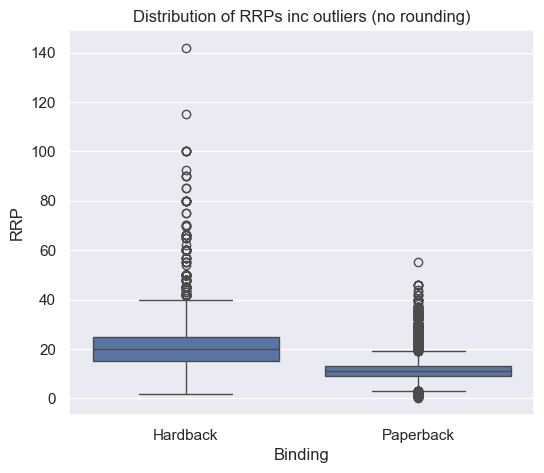

In [15]:
# Show RRP boxplots inc outliers before rounding
sns.set_theme(rc={"figure.figsize": (6, 5)})
ax = sns.boxplot(x="Binding", y="RRP", data=df)
ax.set_title("Distribution of RRPs inc outliers (no rounding)")
plt.show()

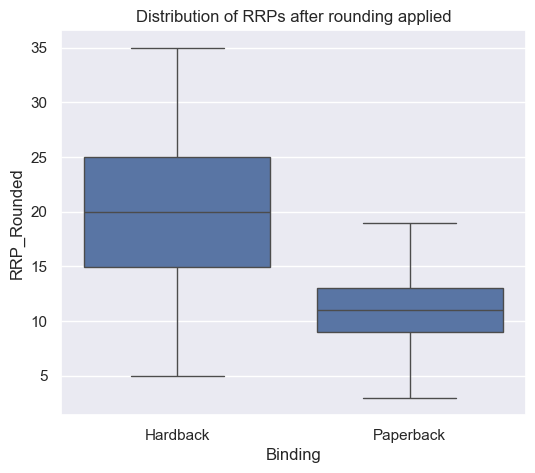

In [16]:
# Drop rows with non-standard RRPs
df = df[df["RRP_Rounded"] > 0]

# Show boxplots after rounding and with outliers removed
ax = sns.boxplot(x="Binding", y="RRP_Rounded", data=df, showfliers=False)
ax.set_title("Distribution of RRPs after rounding applied")
plt.show()

In [17]:
# Drop original RRP column
df = df.drop(columns=["RRP"])

In [18]:
df.shape # 48,394 rows remaining after outliers dropped

(48394, 8)

## Binding

In [19]:
df["Binding"].value_counts() # 32,567 PBs, 15,827 HBs

Binding
Paperback    32567
Hardback     15827
Name: count, dtype: int64

Encode paperbacks as 0, hardbacks as 1. Integer encoding preferred over OHE due to ordinal nature of relationship demonstrated by higher average RRP for HBs than PBs.

In [20]:
df.loc[(df["Binding"] == "Paperback"), "Binding"] = 0
df.loc[(df["Binding"] == "Hardback"), "Binding"] = 1
df["Binding"] = df["Binding"].astype(int)

## Page Counts

Goodreads (GR) data:

In [21]:
df["GR_Pages"].describe()

count    45343.000000
mean       278.642304
std        189.316069
min          0.000000
25%        160.000000
50%        262.000000
75%        352.000000
max       2486.000000
Name: GR_Pages, dtype: float64

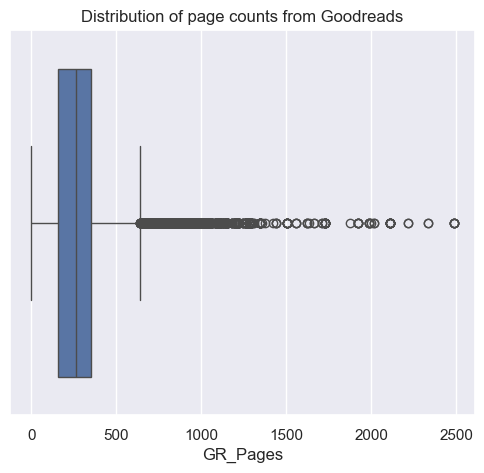

In [22]:
ax = sns.boxplot(x=df["GR_Pages"]) 
ax.set_title("Distribution of page counts from Goodreads")
plt.show()

Google Books (GB) data:

In [23]:
df["GB_Pages"].isnull().sum()

np.int64(5714)

In [24]:
# Describe page count data from Google Books
df["GB_Pages"].describe() 

count    42680.000000
mean       154.061153
std        433.390760
min          0.000000
25%          0.000000
50%         58.000000
75%        284.000000
max      80000.000000
Name: GB_Pages, dtype: float64

In [25]:
# 80,000pp outlier clearly an error. Drop any rows where GB_Pages value is over 10000
df = df[~(df["GB_Pages"] > 10000)]

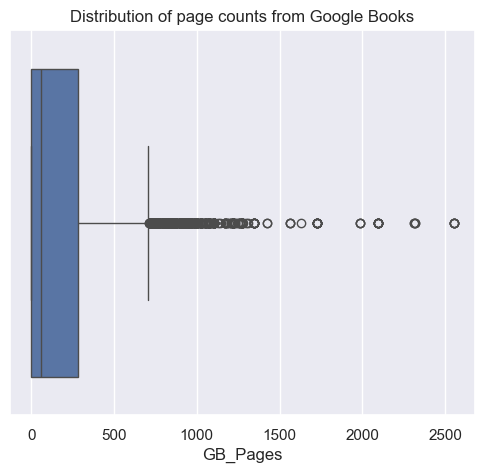

In [26]:
ax = sns.boxplot(x=df["GB_Pages"])
ax.set_title("Distribution of page counts from Google Books")
plt.show()

Fill 3,155 nulls in GR page counts with GB data, or with mean page counts per binding where data not available:

In [27]:
# First fill nulls with 0
df["GB_Pages"] = df["GB_Pages"].fillna(0)
df["GR_Pages"] = df["GR_Pages"].fillna(0)

In [28]:
# Fill GR_Pages nulls with value from GB_Pages
df["Pages"] = df.apply(
    lambda row: (
        row["GB_Pages"]
        if (row["GR_Pages"] == 0) and (row["GB_Pages"] > 0)
        else row["GR_Pages"]
    ),
    axis=1,
)

In [29]:
# Calculate mean page counts for both formats
mean_pb_pages = round(df.loc[df["Binding"] == 0]["Pages"].mean()) # Mean paperback page count = 268
mean_hb_pages = round(df.loc[df["Binding"] == 1]["Pages"].mean()) # Mean hardback page count = 275
print(mean_pb_pages, mean_hb_pages)

268 275


In [30]:
# Fill zero values with mean page counts per format
df.loc[(df["Binding"] == 0) & (df["Pages"] == 0), "Pages"] = mean_pb_pages
df.loc[(df["Binding"] == 1) & (df["Pages"] == 0), "Pages"] = mean_hb_pages

In [31]:
# Convert Pages column from float to int
df["Pages"] = df["Pages"].astype(int)

# Drop now redundant GR_Pages and GB_Pages columns
df = df.drop(columns=["GR_Pages", "GB_Pages"])

## Publishers

In [32]:
df["Publisher Group"].value_counts()

Publisher Group
Random House Grp                  4916
Penguin Grp                       4425
HarperCollins Grp                 4260
Octopus Publishing Grp            2835
Other Publisher Groups            2363
                                  ... 
The Rowman & Littlefield Publi       1
Oldcastle Books Grp                  1
Scholastic Ltd. Grp                  1
Panini Books Grp                     1
New River Books                      1
Name: count, Length: 248, dtype: int64

Group titles by publishing house:

In [33]:
# Define publishing houses and their respective divisions
publishers = {
    "PRH": [
        "Dorling Kindersley Grp",
        "Penguin Grp",
        "Random House Grp",
        "Transworld Grp",
    ],
    "Hachette": [
        "Hachette Books Ireland Grp",
        "Hachette Children's Grp",
        "Headline Grp",
        "Hodder & Stoughton Grp",
        "John Murray Press Group",
        "Little, Brown Book Grp",
        "Octopus Publishing Grp",
        "Orion Grp",
        "Perseus Books Group",
        "Quercus Grp",
    ],
    "Pan_Mac": [
        "Pan Macmillan Grp",
    ],
    "HC": [
        "HarperCollins Grp",
    ],
    "SS": [
        "Simon & Schuster Grp",
    ],
    "Bonnier": [
        "Bonnier Books UK Publishing Gr",
    ],
    "Bloomsbury": [
        "Bloomsbury Grp",
    ],
    "IA": [
        "Faber Grp",
        "Atlantic Books Grp",
        "Canongate Grp",
        "Duckworth Books Group",
        "Europa Editions Grp",
        "Fitzcarraldo Editions Grp",
        "Granta Grp",
        "Lonely Planet Grp",
        "Murdoch Books Grp",
        "Oneworld Publications Grp",
        "Profile Books Group",
        "Pushkin Grp",
        "Scribe Publications Group",
        "Swift Press",
    ],
}

# Create function to assign divisions to publishers (or "Other" if not a member of a major group)
def get_publisher(publisher_group):
    for publisher, divisions in publishers.items():
        if publisher_group in divisions:
            return publisher
    return "Other"

# Assign divisions to publishers
df["Publisher"] = df["Publisher Group"].apply(get_publisher)

In [34]:
df["Publisher"].value_counts()

Publisher
Other         13641
PRH           12350
Hachette       8761
HC             4260
IA             4040
Pan_Mac        1529
Bloomsbury     1435
Bonnier        1370
SS             1007
Name: count, dtype: int64

One-hot encode Publishers and drop original Publisher Group column:

In [35]:
# One-hot encode publishers
df = pd.get_dummies(df, columns=["Publisher"], prefix="", prefix_sep="", dtype=int)

# Drop original Publisher Group columns
df = df.drop(columns=["Publisher Group"])

## Publication Dates

In [36]:
df["Publ Date"].value_counts()

Publ Date
04/10/2018    311
05/10/2017    287
06/10/2016    250
01/06/2017    245
06/09/2018    241
             ... 
28/05/2023      1
06/10/2023      1
27/01/2023      1
14/10/2022      1
31/12/1980      1
Name: count, Length: 3551, dtype: int64

Extract year and month from Publ Date column (exact day not relevant to pricing model so can be dropped):

In [37]:
# Convert to datetime format before extracting dates
df["Publ Date"] = pd.to_datetime(df["Publ Date"], format="%d/%m/%Y")
df["Pub_Year"] = df["Publ Date"].dt.year
df["Pub_Month"] = df["Publ Date"].dt.month

# Drop original column
df = df.drop(columns=["Publ Date"])

## Genres and Subgenres

In [38]:
df["Product Class"]. value_counts()

Product Class
T14.3  Travel & Holiday Guides: General                  3306
T16.0  Food & Drink: General                             2819
T11.6  Handicrafts, Arts & Crafts                        1909
T4.0A  Autobiography: General                            1811
T13.0  Humour: Collections & General                     1656
                                                         ... 
T12.0  Transport: General                                   6
T5.7T  History: Textbooks & Study Guides                    3
T3.6  Literary Theory                                       3
T12.3  Vehicle Maintenance & Manuals                        3
T15.0T  Sports Studies & PE: Textbooks & Study Guides       1
Name: count, Length: 139, dtype: int64

Data in original column consists of a Thema code (T-code) followed by a descriptive string. T-code is made up of an overall genre class from 1&ndash;18, a decimal point, a subgenre class from 0&ndash;9 and an optional qualifier letter ("A" or "T").

Export and integer encode genres, subgenres and qualifiers from T-code:

In [39]:
# Define top-level genres from Thema
genre_dict = {
    1: "The Arts",
    2: "Encyclopedias and Reference Works",
    3: "Literature and Literary Studies",
    4: "Biography and Autobiography",
    5: "History and Archaeology",
    6: "Religion and Belief Systems",
    7: "Politics and Government",
    8: "Popular Science, Popular Culture and Natural History",
    9: "Health and Relationships",
    10: "Mind, Body, Spirit",
    11: "Lifestyle, Hobbies and Leisure",
    12: "Transport",
    13: "Humour, Trivia and Puzzles",
    14: "Travel and Holiday",
    15: "Sports and Active Pursuits",
    16: "Cookery, Food and Drink",
    17: "Personal Development and Practical Advice",
    18: "True Crime and True Stories",
}
qualifiers_dict = {"": "0", "A": "1", "T": "2"}

# Create new genre DF by exporting unique values from "Product Class" column
genre_df = pd.DataFrame(df["Product Class"].unique(), columns=["Full_String"])

# Split the "T0.0"-formatted codes into Genre/Subgenre codes, qualifiers and descriptions
pattern = (
    r"T(?P<Genre_Code>\d{1,2})\.(?P<Sub_Code>\d{1})(?P<Qualifier>\w?)\s(?P<Sub_Desc>.+)"
)
expanded_df = genre_df["Full_String"].str.extract(pattern)
genre_df = pd.concat([genre_df, expanded_df], axis=1)
genre_df[["Genre_Code", "Sub_Code"]] = genre_df[["Genre_Code", "Sub_Code"]].astype(int)

# Convert qualifiers to numeric values from qualifiers_dict
genre_df["Qualifier"] = genre_df["Qualifier"].replace(qualifiers_dict)
genre_df["Qualifier"] = genre_df["Qualifier"].astype(int)

# Add Genre_Desc column using values from genre_dict, tidy up order and export to CSV
genre_df["Genre_Desc"] = genre_df["Genre_Code"].astype(int).map(genre_dict)
genre_df = genre_df.iloc[:, [0, 1, 2, 3, 5, 4]]
genre_df = genre_df.sort_values(by=["Genre_Code", "Sub_Code"]).reset_index(drop=True)
genre_df.to_csv("./data/genres.csv", index=False)

# # Add newly defined genre codes and drop "Product Class" and "Full_String" columns
df = df.merge(
    genre_df[["Full_String", "Genre_Code", "Sub_Code", "Qualifier"]],
    left_on="Product Class",
    right_on="Full_String",
    how="left",
)
df = df.drop(columns=["Product Class", "Full_String"])

## Sales Year

In [40]:
df.shape

(48393, 18)

In [41]:
df["Sales_Year"].value_counts()

Sales_Year
2022    4865
2017    4854
2023    4850
2016    4847
2019    4843
2018    4836
2021    4836
2020    4824
2015    4823
2014    4815
Name: count, dtype: int64

To calculate whether sales year is relevant to the pricing model, we need to look at whether there are any trends in the data suggesting a correlation between sales year and RRP.

Display YoY variation in mean RRP by binding:

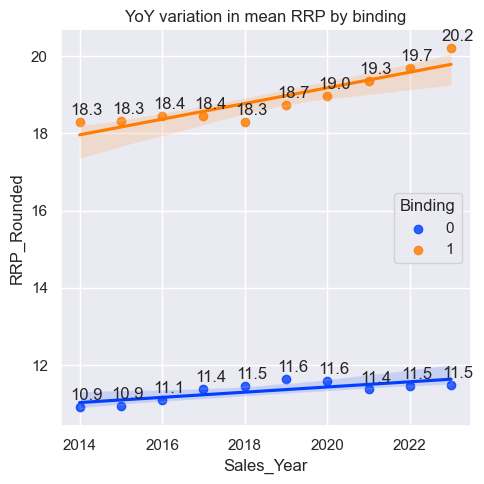

In [42]:
# Create temporary DF grouped by Sales_Year and Binding for ease of further analysis
temp_df = df.groupby(["Sales_Year", "Binding"])["RRP_Rounded"].mean().unstack(level=1)

# Reshape temporary DF for plotting
plot_df = temp_df.reset_index().melt(
    id_vars="Sales_Year", var_name="Binding", value_name="RRP_Rounded"
)
years = plot_df["Sales_Year"].unique()

# Create the plot
ax = sns.lmplot(
    data=plot_df,
    x="Sales_Year",
    y="RRP_Rounded",
    hue="Binding",
    palette="bright",
    facet_kws=dict(legend_out=False),
)

# Add mean RRP values to plot points
axes = ax.axes[0, 0]
for i, row in plot_df.iterrows():
    axes.annotate(
        f'{row["RRP_Rounded"]:.1f}', 
        (row["Sales_Year"], row["RRP_Rounded"]),
        textcoords="offset points",
        xytext=(5,5), 
        ha='center'
    )

# Set plot title and labels
axes.set(title="YoY variation in mean RRP by binding", xlabel="Sales_Year", ylabel="RRP_Rounded")
plt.tight_layout()
plt.show()

Clear trend indicating both HB and PB RRPs have increased over the timeframe of the dataset, so sales year should be pertinent for the model - keep accordingly.

## Final checks

In [43]:
df.head()

,Sales_Year,Binding,RRP_Rounded,Pages,Bloomsbury,Bonnier,HC,Hachette,IA,Other,PRH,Pan_Mac,SS,Pub_Year,Pub_Month,Genre_Code,Sub_Code,Qualifier
0,2014,1,20.00,256,0,0,0,0,0,1,0,0,0,2014,9,2,0,0
1,2014,1,16.99,275,0,0,0,1,0,0,0,0,0,2014,10,4,1,1
2,2014,1,30.00,320,0,0,0,0,0,0,1,0,0,2014,2,16,0,0
3,2014,1,30.00,408,0,0,0,0,0,0,1,0,0,2014,8,16,0,0
4,2014,1,20.00,320,0,0,0,0,0,0,1,0,0,2014,5,4,4,1


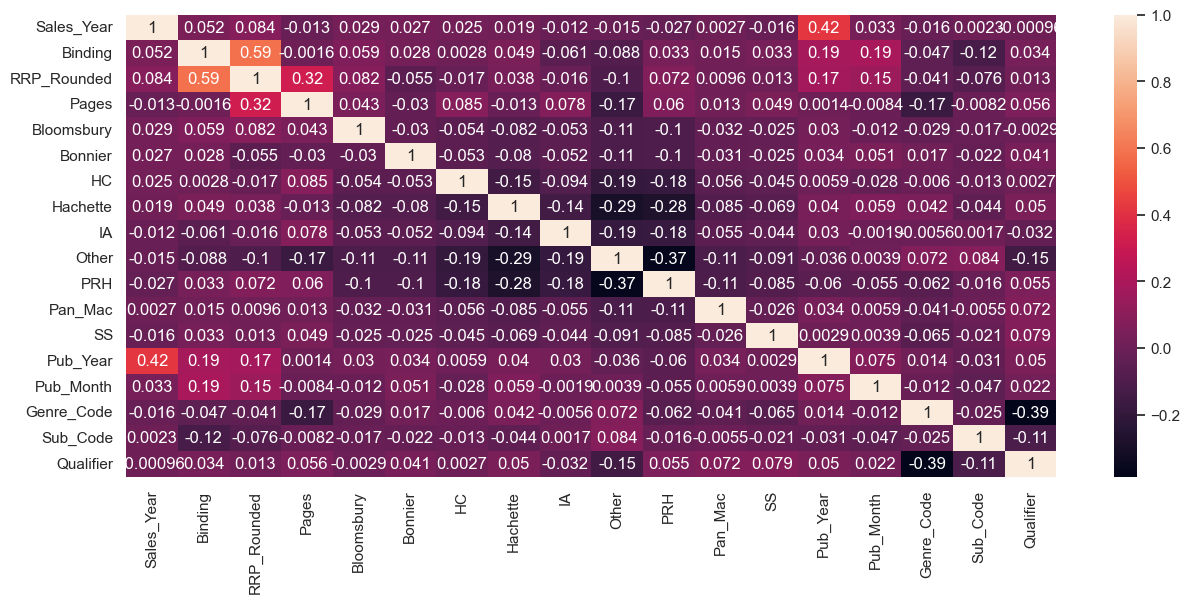

In [44]:
# Plot heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [45]:
df.dtypes

Sales_Year       int64
Binding          int64
RRP_Rounded    float64
Pages            int64
Bloomsbury       int64
Bonnier          int64
HC               int64
Hachette         int64
IA               int64
Other            int64
PRH              int64
Pan_Mac          int64
SS               int64
Pub_Year         int32
Pub_Month        int32
Genre_Code       int64
Sub_Code         int64
Qualifier        int64
dtype: object

In [46]:
df.shape # 48,393 rows remaining of the original 50000

(48393, 18)

# Model selection and optimising

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost

### Set up train-test split and scaling

In [48]:
# Define X and y values
X = df.drop(columns=["RRP_Rounded"])
y = df["RRP_Rounded"]

# Set up train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

# Standardise features with both StandardScaler and MinMaxScaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)
X_test_mm = mm.transform(X_test)

(38714, 17) (9679, 17)


### Model selection

#### LinearRegression

In [49]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

19.75173775004074


Testing with scaling applied

In [50]:
# StandardScaler
model = LinearRegression()
model.fit(X_train_ss, y_train)
y_pred_ss = model.predict(X_test_ss)
mse_ss = mean_squared_error(y_test, y_pred_ss)
print(mse_ss)

# MinMaxScaler
model.fit(X_train_mm, y_train)
y_pred_mm = model.predict(X_test_mm)
mse_mm = mean_squared_error(y_test, y_pred_mm)
print(mse_mm) # No tangible difference 

19.75217312770482
19.752685028753586


#### DecisionTreeRegressor

In [51]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

8.915538797772278


Significant improvement on LinearRegression. Test different values for max_depth:

In [52]:
values = [i for i in range(1, 21)]
test_scores = []
for i in values:
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    test_scores.append(mse)
test_scores

[np.float64(24.36695216991099),
 np.float64(19.866182326797702),
 np.float64(18.42701304532867),
 np.float64(17.341088441052793),
 np.float64(16.202933406803997),
 np.float64(14.990008474260488),
 np.float64(13.746150290438715),
 np.float64(12.997589880254726),
 np.float64(12.11936428182481),
 np.float64(11.434057224267779),
 np.float64(10.562357507529423),
 np.float64(10.07111937093829),
 np.float64(9.619630199385465),
 np.float64(9.379471208188404),
 np.float64(9.283253276848415),
 np.float64(8.907659510238739),
 np.float64(8.448178404616943),
 np.float64(8.906502485059027),
 np.float64(8.742992289303734),
 np.float64(8.75100867661906)]

#### XGBoost

In [53]:
# XGBoost
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

7.843445715481485


Significant improvement again - possible candidate for further tuning.

#### RandomForestRegressor

In [54]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

5.022721668634979


Best yet. Proceed with XGB and RFR as best candidates.

## Tuning hyperparameters

#### RFR

Start by testing different values for n_estimators:

In [60]:
values = [i for i in range(100, 301, 10)]
test_scores = []
for i in values:
    model = RandomForestRegressor(n_estimators=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    test_scores.append(mse)
test_scores

[np.float64(5.060894318504323),
 np.float64(5.015621786758849),
 np.float64(5.046868861624948),
 np.float64(5.016486584128393),
 np.float64(5.053308330287552),
 np.float64(5.034739275377989),
 np.float64(5.032982177025985),
 np.float64(4.987470784046314),
 np.float64(5.044251565747195),
 np.float64(5.013334167412619),
 np.float64(5.027607407627082),
 np.float64(4.996097163293722),
 np.float64(5.015936639532515),
 np.float64(5.02288478161377),
 np.float64(4.977760669503133),
 np.float64(5.013452145301064),
 np.float64(5.018468742934282),
 np.float64(5.011373694288892),
 np.float64(5.014872304976121),
 np.float64(4.997911908449922),
 np.float64(4.9995312392913025)]

Next try a randomised search of some alternative parameter values:

In [56]:
param_grid = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [10, 20, 50, 100, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", "log2", 0.2, 0.5, 0.8],
    "bootstrap": [True, False],
}

model = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print(f"Best RFR parameters: {random_search.best_params_}")

best_rfr_model = random_search.best_estimator_

Best settings:

In [57]:
y_pred = best_rfr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)

4.855451950695087
0.8685609345884961


#### XGBoost

Repeat same process for XGBoost, first iterating through n_estimators:

In [61]:
values = [i for i in range(100, 301, 10)]
test_scores = []
for i in values:
    model = xgboost.XGBRegressor(n_estimators=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    test_scores.append(mse)
test_scores

[np.float64(7.843445715481485),
 np.float64(7.696324440421894),
 np.float64(7.609589683809977),
 np.float64(7.518071557638135),
 np.float64(7.403854625778251),
 np.float64(7.307109374331303),
 np.float64(7.217671948675508),
 np.float64(7.129462947789697),
 np.float64(7.047658461915902),
 np.float64(6.9716604857715305),
 np.float64(6.920044622009057),
 np.float64(6.858452269586581),
 np.float64(6.792132105449585),
 np.float64(6.741483368266587),
 np.float64(6.694112354706641),
 np.float64(6.631477635033896),
 np.float64(6.601676517046874),
 np.float64(6.56002621063512),
 np.float64(6.509382031244549),
 np.float64(6.471582242171887),
 np.float64(6.413583166815761)]

Then carrying out a randomised search of some alternative params:

In [62]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [300, 500, 1000],
    "max_depth": [3, 5, 7, 10],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.5, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
}

model = xgboost.XGBRegressor()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print(f"Best XGB parameters: {random_search.best_params_}")

best_xgb_model = random_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best XGB parameters: {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [65]:
y_pred = best_xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)

4.830333448440264
0.8692409026933062


#### Cross-validate both models

In [ ]:
rfr_scores = cross_val_score(best_rfr_model, X, y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (rfr_scores.mean(), rfr_scores.std()))

In [ ]:
xgb_scores = cross_val_score(best_xgb_model, X, y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (xgb_scores.mean(), xgb_scores.std()))

In [59]:
# fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
# PredictionErrorDisplay.from_predictions(
#     y,
#     y_pred=y_pred,
#     kind="actual_vs_predicted",
#     subsample=100,
#     ax=axs[0],
#     random_state=0,
# )
# axs[0].set_title("Actual vs. Predicted values")
# PredictionErrorDisplay.from_predictions(
#     y_train,
#     y_pred=y_pred,
#     kind="residual_vs_predicted",
#     subsample=100,
#     ax=axs[1],
#     random_state=0,
# )
# axs[1].set_title("Residuals vs. Predicted Values")
# fig.suptitle("Plotting cross-validated predictions")
# plt.tight_layout()
# plt.show()